### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 17th at 11.59pm CST
---

## Only one problem this week

This problem is mostly about generative classification, but will include one discriminative classifer that we'll meet in `Lecture_20`.

**1. Use the following code snippet to read in SDSS galaxy color data.**
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
**This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?**


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


**3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.**


**4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


**5. Repeat (4) for Quadratic Discriminant Analysis.**


**6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.**


**7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance.**


**8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance.** 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [103]:
# IMPORTS
##########
##########

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from astroML.classification import GMMBayes

### Part 1

In [1]:
#CLD importing data
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()

querying for 50000 objects
SELECT TOP 50000
  p.u, p.g, p.r, p.i, p.z, s.class, s.z, s.zerr
FROM PhotoObj AS p
  JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE 
  p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 20
  AND s.class <> 'UNKNOWN'
  AND s.class <> 'STAR'
  AND s.class <> 'SKY'
  AND s.class <> 'STAR_LATE'
finished.


In [7]:
#CLD the column names are in the dtype specification
data.dtype

dtype([('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

In [8]:
#CLD creating the requested arrays 
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

redshift = data['redshift']
spec_class = data['specClass']

In [17]:
#CLD using the np.unique function to find how many galaxies and how many qso there are
unique, counts = np.unique(spec_class, return_counts=True)
print(unique)
print('The number of galaxies in this sample: '+str(counts[0]))
print("The number of qso's in this sample: "+str(counts[1]))

['GALAXY' 'QSO']
The number of galaxies in this sample: 42922
The number of qso's in this sample: 7078


### Part 2

In [41]:
#CLD making target label array now because it'll be easier to plot with colors coded by labels
labels = np.zeros(len(spec_class))
labels[spec_class=='GALAXY'] = 0
labels[spec_class=='QSO'] = 1

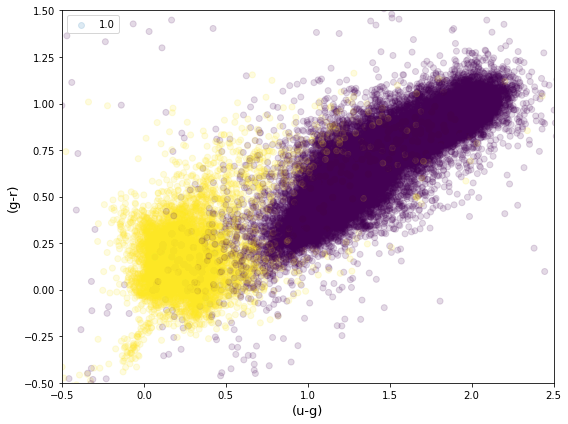

In [44]:
#CLD making the scatter plot and colorcoding by labels
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(u_g, g_r, c=labels, alpha=0.15) #CLD turned the alpha
#CLD way down to see clustering better
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5,1.5)
ax.set_xlabel('(u-g)', fontsize=13)
ax.set_ylabel('(g-r)', fontsize=13)
ax.legend(labels)
fig.tight_layout()
plt.show(fig)

### Part 3

In [51]:
#CLD creating the color and redshift array X
X = np.array([u_g, g_r, r_i, i_z, redshift]).T

In [52]:
#CLD already made the target label array with 0=Galaxy and 1=QSO
#CLD so moving on to splitting up the test and train arrays
placeholder = train_test_split(X, labels, test_size=0.2)
train_X = placeholder[0]
train_labels = placeholder[2]
test_X = placeholder[1]
test_labels = placeholder[3]

### Part 4

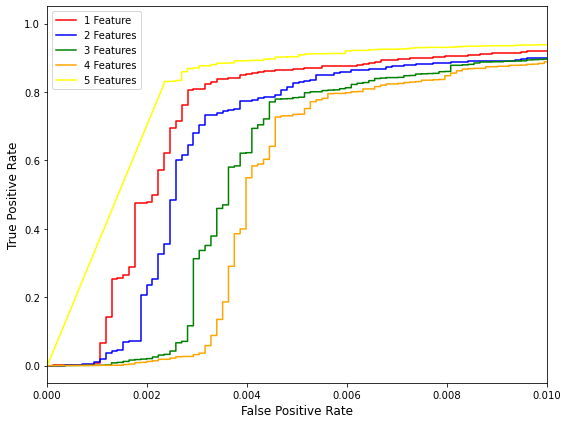

In [93]:
#CLD making the for loop to predict the class while adding more and more features from X
#CLD in essence looping over the columns
fprs = []
tprs = []
for i in range(X.shape[1]):#CLD +1 so goes over full range of features
    gnb = GaussianNB()
    gnb.fit(train_X[:,:i+1], train_labels)
    labels_probs = gnb.predict_proba(test_X[:,:i+1])[:,1] #CLD the probablity for it to be a QSO should be the second column
    #CLD based on the classes attribute of the gnb model I made
    fpr, tpr, thresh = roc_curve(test_labels, labels_probs)
    fpr = np.concatenate([[0], fpr]) #CLD adding (0,0) as first point
    tpr = np.concatenate([[0], tpr])
    fprs.append(fpr)
    tprs.append(tpr)
    
#CLD plotting the ROC curves
colors = ['red', 'blue', 'green', 'orange', 'yellow']
names = ['1 Feature', '2 Features', '3 Features', '4 Features', '5 Features']
fig,ax = plt.subplots(figsize=(8,6))
for f, t, c, l in zip(fprs, tprs, colors, names):
    ax.plot(f, t, c=c, label=l)
ax.set_xlim(0, 0.01)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show(fig)

Maybe the fifth feature makes the classification trivially easy?

### Part 5

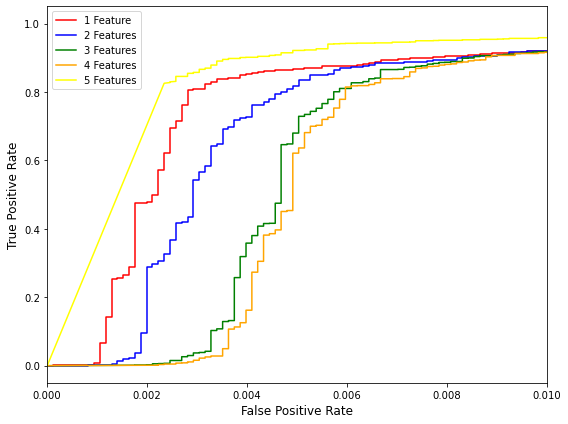

In [94]:
#CLD repeating same for loop from above but with qda
#CLD making the for loop to predict the class while adding more and more features from X
#CLD in essence looping over the columns
fprs1 = []
tprs1 = []
for i in range(X.shape[1]):#CLD +1 so goes over full range of features
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(train_X[:,:i+1], train_labels)
    labels_probs1 = qda.predict_proba(test_X[:,:i+1])[:,1] #CLD the probablity for it to be a QSO should be the second column
    #CLD based on the classes attribute of the gnb model I made
    fpr1, tpr1, thresh1 = roc_curve(test_labels, labels_probs1)
    fpr1 = np.concatenate([[0], fpr1]) #CLD adding (0,0) as first point
    tpr1 = np.concatenate([[0], tpr1])
    fprs1.append(fpr1)
    tprs1.append(tpr1)
    
#CLD plotting the ROC curves
colors = ['red', 'blue', 'green', 'orange', 'yellow']
names = ['1 Feature', '2 Features', '3 Features', '4 Features', '5 Features']
fig,ax = plt.subplots(figsize=(8,6))
for f, t, c, l in zip(fprs1, tprs1, colors, names):
    ax.plot(f, t, c=c, label=l)
ax.set_xlim(0, 0.01)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show(fig)

Again, it seems to get steadily harder, until the addition of redshift.

### Part 6

In [114]:
#CLD setting up the four loop for GMM bayes
fprs2 = []
tprs2 = []
for i in range(10):
    print(i+1) #CLD making sure I'm looping over the right number of components
    gmm = GMMBayes(n_components=i+1) #CLD do I need the other args seen in lecutre notebook??
    gmm.fit(train_X[:,:4], train_labels) #CLD fitting just the color features not including redshift
    labels_probs2 = gmm.predict_proba(test_X[:,:4])[:,1]
    
    fpr2, tpr2, thresh2 = roc_curve(test_labels, labels_probs2)
    fpr2 = np.concatenate([[0], fpr2]) #CLD adding (0,0) as first point
    tpr2 = np.concatenate([[0], tpr2])
    fprs2.append(fpr2)
    tprs2.append(tpr2)

1
2
3
4
5
6
7
8
9
10


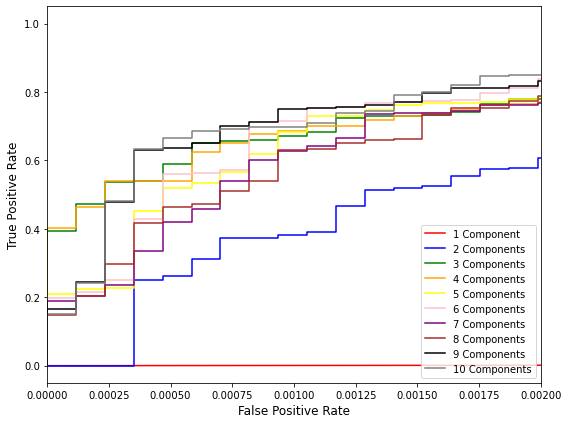

In [115]:
#CLD plotting the ROC curve for number of components 
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'pink', 'purple', 'brown', 'black', 'grey']
names = ['1 Component', '2 Components', '3 Components', '4 Components', '5 Components', '6 Components', 
        '7 Components', '8 Components', '9 Components', '10 Components']
fig,ax = plt.subplots(figsize=(8,6))
for f, t, c, l in zip(fprs2, tprs2, colors, names):
    ax.plot(f, t, c=c, label=l)
ax.set_xlim(0, 0.002)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show(fig)

It seems like after 5 components, the preformances are pretty similar, although 9 and 10 do maximize the area under the curve the best.

### Part 7

In [110]:
#CLD setting up the four loop for KNearestNeighbors
fprs3 = []
tprs3 = []
for i in range(int((100-5)/10)+1):
    print(5+(i*10)) #CLD making sure I'm looping over the right number of components
    knn = KNeighborsClassifier(n_neighbors=i+1) 
    knn.fit(train_X[:,:4], train_labels) #CLD fitting just the color features ie not including redshift
    labels_probs3 = knn.predict_proba(test_X[:,:4])[:,1]
    
    fpr3, tpr3, thresh3 = roc_curve(test_labels, labels_probs3)
    fpr3 = np.concatenate([[0], fpr3]) #CLD adding (0,0) as first point
    tpr3 = np.concatenate([[0], tpr3])
    fprs3.append(fpr3)
    tprs3.append(tpr3)

5
15
25
35
45
55
65
75
85
95


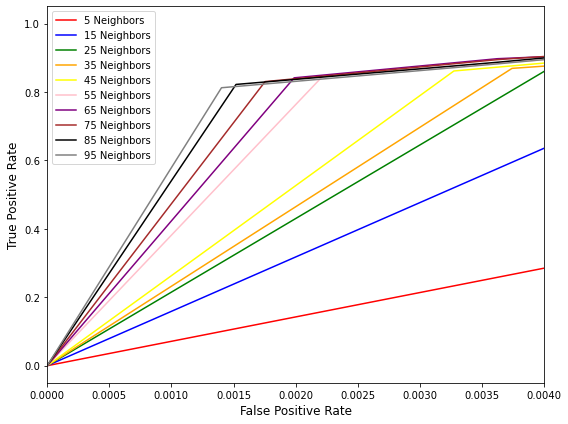

In [113]:
#CLD plotting the ROC curve for number of components 
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'pink', 'purple', 'brown', 'black', 'grey']
names = ['5 Neighbors', '15 Neighbors', '25 Neighbors', '35 Neighbors', '45 Neighbors', '55 Neighbors', 
        '65 Neighbors', '75 Neighbors', '85 Neighbors', '95 Neighbors']
fig,ax = plt.subplots(figsize=(8,6))
for f, t, c, l in zip(fprs3, tprs3, colors, names):
    ax.plot(f, t, c=c, label=l)
ax.set_xlim(0, 0.004)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show(fig)

From the above zoom in on the graph, it seems as if 95 neighbors leads to the best classification

### Part 8

In [116]:
#CLD setting up the four loop for Decision Tree
fprs4 = []
tprs4 = []
for i in range(10):
    print(i+1) #CLD making sure I'm looping over the right number of components
    dtc = DecisionTreeClassifier(max_depth=i+1) 
    dtc.fit(train_X[:,:4], train_labels) #CLD fitting just the color features ie not including redshift
    labels_probs4 = dtc.predict_proba(test_X[:,:4])[:,1]
    
    fpr4, tpr4, thresh4 = roc_curve(test_labels, labels_probs4)
    fpr4 = np.concatenate([[0], fpr4]) #CLD adding (0,0) as first point
    tpr4 = np.concatenate([[0], tpr4])
    fprs4.append(fpr4)
    tprs4.append(tpr4)

1
2
3
4
5
6
7
8
9
10


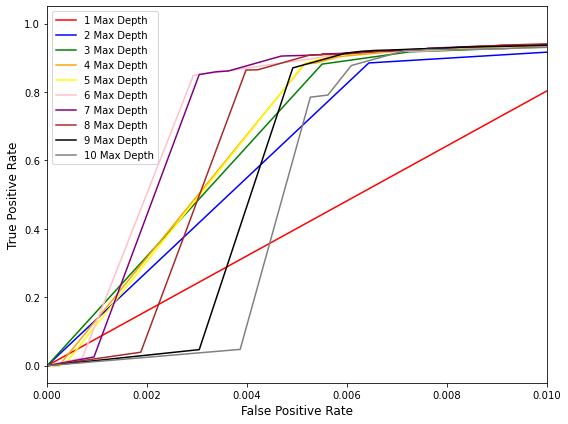

In [118]:
#CLD plotting the ROC curve for number of components 
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'pink', 'purple', 'brown', 'black', 'grey']
names = ['1 Max Depth', '2 Max Depth', '3 Max Depth', '4 Max Depth', '5 Max Depth', '6 Max Depth', 
        '7 Max Depth', '8 Max Depth', '9 Max Depth', '10 Max Depth']
fig,ax = plt.subplots(figsize=(8,6))
for f, t, c, l in zip(fprs4, tprs4, colors, names):
    ax.plot(f, t, c=c, label=l)
ax.set_xlim(0, 0.01)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show(fig)

It looks as if 6 max depth does the best for this model.

### Part 9